In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

# **8:1:1**

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ETH.csv')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
23/23 [==============================] - 4s 73ms/step - loss: 0.0298 - val_loss: 8.7038e-04
Epoch 2/100
23/23 [==============================] - 1s 49ms/step - loss: 0.0025 - val_loss: 2.6144e-04
Epoch 3/100
23/23 [==============================] - 1s 50ms/step - loss: 7.6806e-04 - val_loss: 9.4360e-05
Epoch 4/100
23/23 [==============================] - 1s 51ms/step - loss: 6.5359e-04 - val_loss: 9.4046e-05
Epoch 5/100
23/23 [==============================] - 1s 49ms/step - loss: 6.2516e-04 - val_loss: 8.6722e-05
Epoch 6/100
23/23 [==============================] - 1s 50ms/step - loss: 6.0296e-04 - val_loss: 8.5521e-05
Epoch 7/100
23/23 [==============================] - 2s 85ms/step - loss: 5.8174e-04 - val_loss: 8.2416e-05
Epoch 8/100
23/23 [==============================] - 2s 80ms/step - loss: 5.5753e-04 - val_loss: 8.4575e-05
Epoch 9/100
23/23 [==============================] - 1s 51ms/step - loss: 5.4912e-04 - val_loss: 7.7634e-05
Epoch 10/100
23/23 [================

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 12ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
# 12. Đánh giá độ chính xác thuật toán
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

valid_mae = np.mean(abs(y_pred_val - yval))
test_mae = np.mean(abs(y_pred - ytest))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

valid_mape = np.mean(np.abs(y_pred_val - yval)/np.abs(y_pred_val))
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 3345.613354426282
Testing RMSE: 1706.801659194307
Validation MAE: 3331.078097397867
Testing MAE: 1704.2757548355567
Validation MAPE: 0.9997943603070049
Testing MAPE: 0.9998041682718457


In [13]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=130
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.47270777 0.47521643 0.52568486 0.53366439 0.51342419 0.52451382
 0.50231726 0.51063859 0.52687334 0.51425567 0.50120646 0.50598788
 0.50175317 0.49841889 0.46798451 0.45306573 0.45155041 0.4481788
 0.45870516 0.45885113 0.45658009 0.46931128 0.4751455  0.46196897
 0.46649526 0.46739144 0.4648391  0.46345822 0.46544542 0.48103901
 0.4920022  0.49118573 0.50556612 0.50848278 0.50983178 0.54185262
 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648 0.588834
 0.60256939 0.6174432  0.60826562 0.60840427 0.59790777 0.61295149
 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693 0.70710649
 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953 0.80054378
 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402 0.8286433
 0.80241398 0.77095152 0.72578276 0.75121155 0.72474585 0.6480962
 0.72376913 0.71942968 0.68554606 0.68616416 0.71127167 0.74025132
 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019 0.75236934
 0.72199032 0.67353848 0.68081434 0.68477024 0.68239753

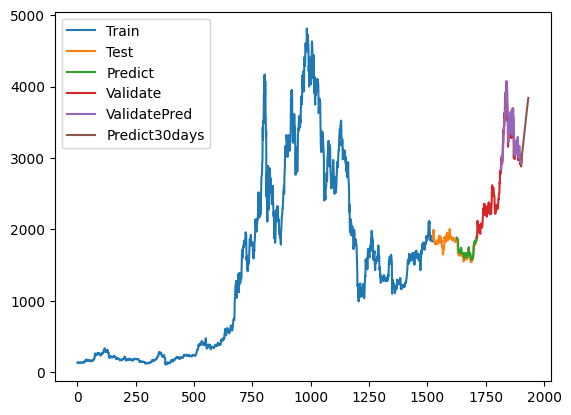

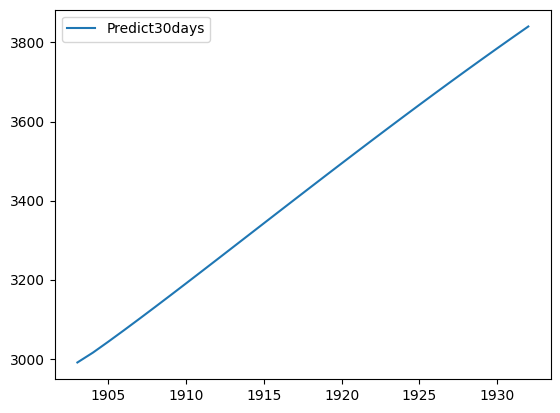

In [14]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# Vẽ hidnh
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict30days'])
plt.show()

In [15]:
# 15. Dự báo 60 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=130
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.47270777 0.47521643 0.52568486 0.53366439 0.51342419 0.52451382
 0.50231726 0.51063859 0.52687334 0.51425567 0.50120646 0.50598788
 0.50175317 0.49841889 0.46798451 0.45306573 0.45155041 0.4481788
 0.45870516 0.45885113 0.45658009 0.46931128 0.4751455  0.46196897
 0.46649526 0.46739144 0.4648391  0.46345822 0.46544542 0.48103901
 0.4920022  0.49118573 0.50556612 0.50848278 0.50983178 0.54185262
 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648 0.588834
 0.60256939 0.6174432  0.60826562 0.60840427 0.59790777 0.61295149
 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693 0.70710649
 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953 0.80054378
 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402 0.8286433
 0.80241398 0.77095152 0.72578276 0.75121155 0.72474585 0.6480962
 0.72376913 0.71942968 0.68554606 0.68616416 0.71127167 0.74025132
 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019 0.75236934
 0.72199032 0.67353848 0.68081434 0.68477024 0.68239753

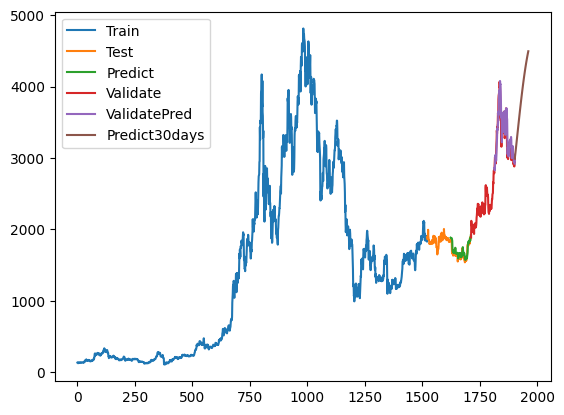

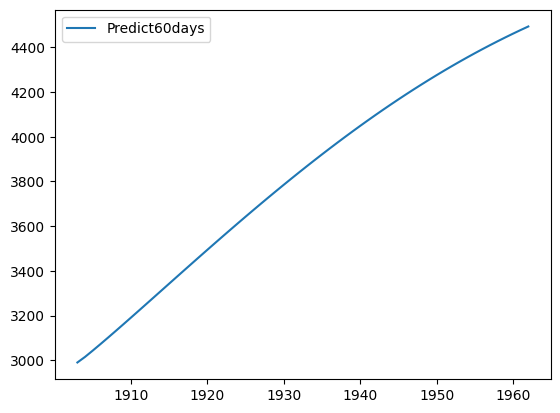

In [16]:
# 16.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# Vẽ hình
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict60days'])
plt.show()

In [17]:
# 17. Dự báo 90 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=130
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.47270777 0.47521643 0.52568486 0.53366439 0.51342419 0.52451382
 0.50231726 0.51063859 0.52687334 0.51425567 0.50120646 0.50598788
 0.50175317 0.49841889 0.46798451 0.45306573 0.45155041 0.4481788
 0.45870516 0.45885113 0.45658009 0.46931128 0.4751455  0.46196897
 0.46649526 0.46739144 0.4648391  0.46345822 0.46544542 0.48103901
 0.4920022  0.49118573 0.50556612 0.50848278 0.50983178 0.54185262
 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648 0.588834
 0.60256939 0.6174432  0.60826562 0.60840427 0.59790777 0.61295149
 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693 0.70710649
 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953 0.80054378
 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402 0.8286433
 0.80241398 0.77095152 0.72578276 0.75121155 0.72474585 0.6480962
 0.72376913 0.71942968 0.68554606 0.68616416 0.71127167 0.74025132
 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019 0.75236934
 0.72199032 0.67353848 0.68081434 0.68477024 0.68239753

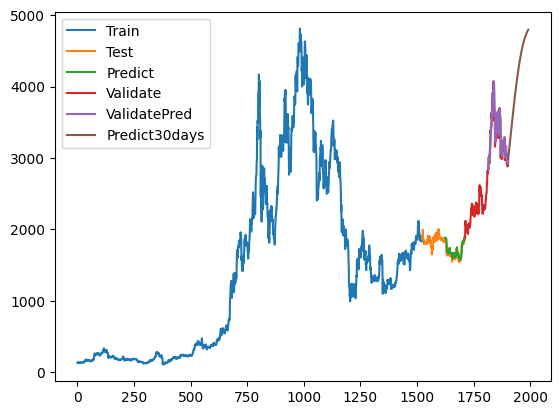

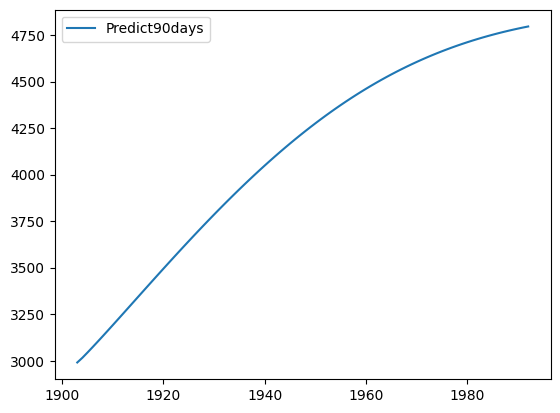

In [18]:
# 18.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# Vẽ hình
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict90days'])
plt.show()

# **7:2:1**

In [19]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ETH.csv')
df1=df.reset_index()['Close']

In [20]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [21]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [22]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [23]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [24]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [25]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 4s 77ms/step - loss: 0.0477 - val_loss: 0.0078
Epoch 2/100
20/20 [==============================] - 1s 54ms/step - loss: 0.0062 - val_loss: 2.0198e-04
Epoch 3/100
20/20 [==============================] - 1s 53ms/step - loss: 0.0011 - val_loss: 3.7703e-04
Epoch 4/100
20/20 [==============================] - 1s 52ms/step - loss: 8.1849e-04 - val_loss: 1.3555e-04
Epoch 5/100
20/20 [==============================] - 1s 54ms/step - loss: 7.6178e-04 - val_loss: 1.3258e-04
Epoch 6/100
20/20 [==============================] - 2s 87ms/step - loss: 7.5931e-04 - val_loss: 1.3265e-04
Epoch 7/100
20/20 [==============================] - 2s 91ms/step - loss: 7.5148e-04 - val_loss: 1.7097e-04
Epoch 8/100
20/20 [==============================] - 1s 53ms/step - loss: 6.7797e-04 - val_loss: 1.7273e-04
Epoch 9/100
20/20 [==============================] - 1s 54ms/step - loss: 7.1829e-04 - val_loss: 1.1976e-04
Epoch 10/100
20/20 [========================

In [27]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 12ms/step


In [28]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [29]:
# 12. Đánh giá độ chính xác thuật toán
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

valid_mae = np.mean(abs(y_pred_val - yval))
test_mae = np.mean(abs(y_pred - ytest))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

valid_mape = np.mean(np.abs(y_pred_val - yval)/np.abs(y_pred_val))
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 3365.868562235901
Testing RMSE: 1806.2804701264502
Validation MAE: 3351.0040686858447
Testing MAE: 1801.3218090346804
Validation MAPE: 0.999795887114361
Testing MAPE: 0.9998042976643658


In [30]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=131
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.44927542 0.47270777 0.47521643 0.52568486 0.53366439 0.51342419
 0.52451382 0.50231726 0.51063859 0.52687334 0.51425567 0.50120646
 0.50598788 0.50175317 0.49841889 0.46798451 0.45306573 0.45155041
 0.4481788  0.45870516 0.45885113 0.45658009 0.46931128 0.4751455
 0.46196897 0.46649526 0.46739144 0.4648391  0.46345822 0.46544542
 0.48103901 0.4920022  0.49118573 0.50556612 0.50848278 0.50983178
 0.54185262 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648
 0.588834   0.60256939 0.6174432  0.60826562 0.60840427 0.59790777
 0.61295149 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693
 0.70710649 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953
 0.80054378 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402
 0.8286433  0.80241398 0.77095152 0.72578276 0.75121155 0.72474585
 0.6480962  0.72376913 0.71942968 0.68554606 0.68616416 0.71127167
 0.74025132 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019
 0.75236934 0.72199032 0.67353848 0.68081434 0.6847

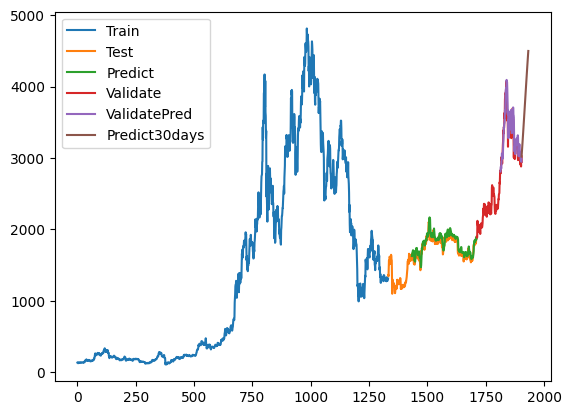

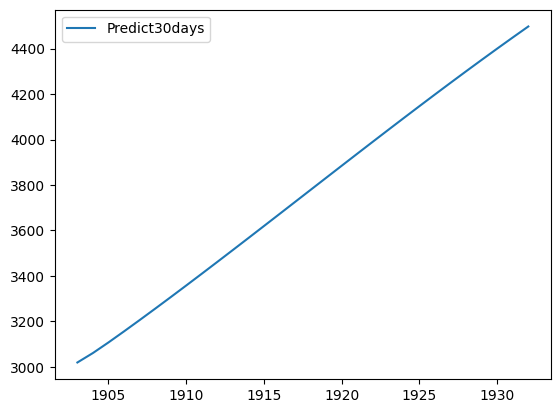

In [31]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# Vẽ hình
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict30days'])
plt.show()

In [32]:
# 15. Dự báo 60 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=131
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.44927542 0.47270777 0.47521643 0.52568486 0.53366439 0.51342419
 0.52451382 0.50231726 0.51063859 0.52687334 0.51425567 0.50120646
 0.50598788 0.50175317 0.49841889 0.46798451 0.45306573 0.45155041
 0.4481788  0.45870516 0.45885113 0.45658009 0.46931128 0.4751455
 0.46196897 0.46649526 0.46739144 0.4648391  0.46345822 0.46544542
 0.48103901 0.4920022  0.49118573 0.50556612 0.50848278 0.50983178
 0.54185262 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648
 0.588834   0.60256939 0.6174432  0.60826562 0.60840427 0.59790777
 0.61295149 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693
 0.70710649 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953
 0.80054378 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402
 0.8286433  0.80241398 0.77095152 0.72578276 0.75121155 0.72474585
 0.6480962  0.72376913 0.71942968 0.68554606 0.68616416 0.71127167
 0.74025132 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019
 0.75236934 0.72199032 0.67353848 0.68081434 0.6847

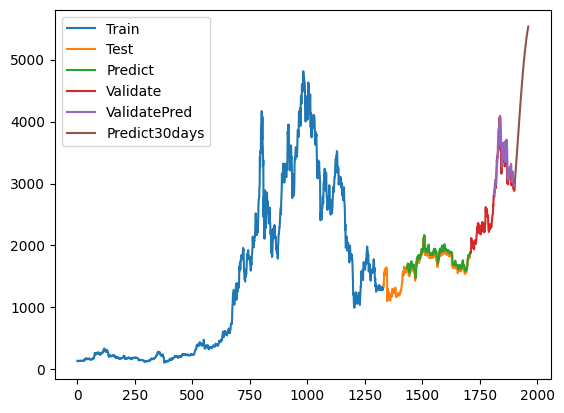

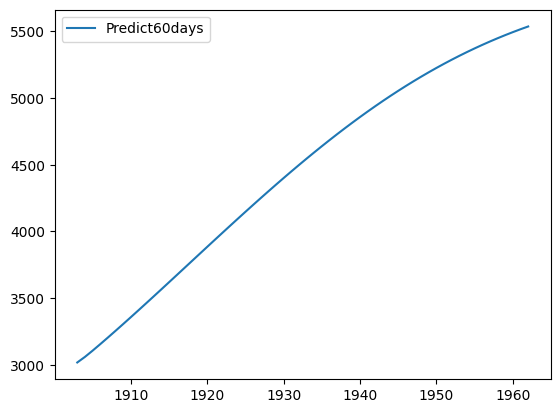

In [33]:
# 16.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# Vẽ hình
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict60days'])
plt.show()

In [34]:
# 17. Dự báo 90 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=131
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.44927542 0.47270777 0.47521643 0.52568486 0.53366439 0.51342419
 0.52451382 0.50231726 0.51063859 0.52687334 0.51425567 0.50120646
 0.50598788 0.50175317 0.49841889 0.46798451 0.45306573 0.45155041
 0.4481788  0.45870516 0.45885113 0.45658009 0.46931128 0.4751455
 0.46196897 0.46649526 0.46739144 0.4648391  0.46345822 0.46544542
 0.48103901 0.4920022  0.49118573 0.50556612 0.50848278 0.50983178
 0.54185262 0.53846419 0.56733105 0.57721657 0.57281636 0.56919648
 0.588834   0.60256939 0.6174432  0.60826562 0.60840427 0.59790777
 0.61295149 0.63854157 0.65264274 0.66657997 0.69660977 0.68729693
 0.70710649 0.70434052 0.7190048  0.74866357 0.73261135 0.78881953
 0.80054378 0.80431139 0.8092796  0.8019998  0.84140269 0.82307402
 0.8286433  0.80241398 0.77095152 0.72578276 0.75121155 0.72474585
 0.6480962  0.72376913 0.71942968 0.68554606 0.68616416 0.71127167
 0.74025132 0.73953263 0.72094495 0.73395759 0.72343159 0.72261019
 0.75236934 0.72199032 0.67353848 0.68081434 0.6847

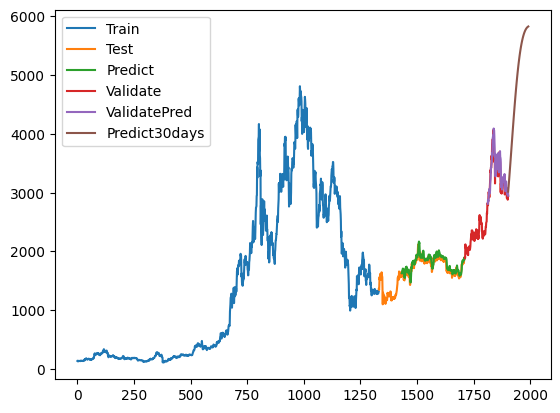

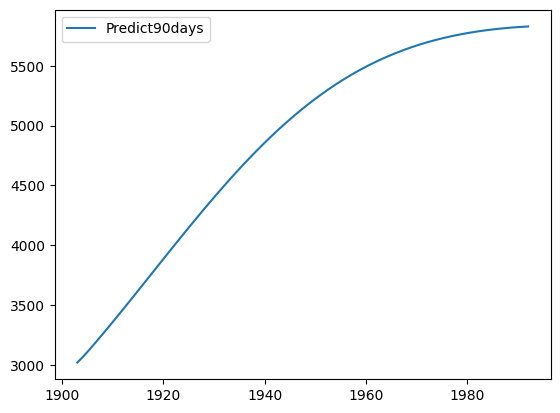

In [35]:
# 18.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# Vẽ hình
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict90days'])
plt.show()

# **6:2:2**

In [36]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ETH.csv')
df1=df.reset_index()['Close']

In [37]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [38]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [39]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [40]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [41]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [42]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [43]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 3s 82ms/step - loss: 0.0679 - val_loss: 0.0189
Epoch 2/100
17/17 [==============================] - 1s 54ms/step - loss: 0.0117 - val_loss: 0.0011
Epoch 3/100
17/17 [==============================] - 1s 74ms/step - loss: 0.0018 - val_loss: 4.2219e-04
Epoch 4/100
17/17 [==============================] - 2s 92ms/step - loss: 0.0013 - val_loss: 3.4166e-04
Epoch 5/100
17/17 [==============================] - 1s 80ms/step - loss: 9.7364e-04 - val_loss: 3.3130e-04
Epoch 6/100
17/17 [==============================] - 1s 54ms/step - loss: 9.3758e-04 - val_loss: 3.9398e-04
Epoch 7/100
17/17 [==============================] - 1s 54ms/step - loss: 9.3392e-04 - val_loss: 3.2623e-04
Epoch 8/100
17/17 [==============================] - 1s 54ms/step - loss: 8.5301e-04 - val_loss: 3.0828e-04
Epoch 9/100
17/17 [==============================] - 1s 54ms/step - loss: 8.2737e-04 - val_loss: 3.0368e-04
Epoch 10/100
17/17 [==============================] 

In [44]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

9/9 [==============================] - 0s 18ms/step


In [45]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [46]:
# 12. Đánh giá độ chính xác thuật toán
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

valid_mae = np.mean(abs(y_pred_val - yval))
test_mae = np.mean(abs(y_pred - ytest))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

valid_mape = np.mean(np.abs(y_pred_val - yval)/np.abs(y_pred_val))
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 2480.5952300909516
Testing RMSE: 1540.5419632775113
Validation MAE: 2386.4561204419333
Testing MAE: 1522.8413350061298
Validation MAPE: 0.9997786244232081
Testing MAPE: 0.9997971224845701


In [48]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=321
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.38582733 0.38856528 0.3923834  0.3883941  0.38285424 0.36967722
 0.37434937 0.37327248 0.3727344  0.37646655 0.37599429 0.37467081
 0.40325706 0.38897126 0.38729508 0.38563929 0.3830793  0.38009154
 0.37826418 0.37868132 0.37891762 0.37313908 0.37830326 0.36996768
 0.37161394 0.37468063 0.3721702  0.37523044 0.37657555 0.37244386
 0.37127796 0.3746024  0.36764663 0.36680578 0.36522679 0.36677418
 0.36517344 0.36506215 0.37120246 0.37088133 0.37012749 0.3693556
 0.36973112 0.36768714 0.36873056 0.36506085 0.36053597 0.33485777
 0.32975546 0.33156911 0.33484045 0.33110056 0.32400142 0.33365409
 0.32954266 0.32805174 0.32664191 0.32902547 0.32795014 0.34438503
 0.33914976 0.32649991 0.32285256 0.32466777 0.3244747  0.32310015
 0.32394544 0.32365254 0.32691661 0.32447898 0.3242715  0.32037199
 0.3065059  0.31518226 0.31849166 0.32252993 0.32564937 0.32428412
 0.32166262 0.32473618 0.32605441 0.32166132 0.31345463 0.31536069
 0.31548607 0.31272005 0.3143088  0.31539236 0.3162

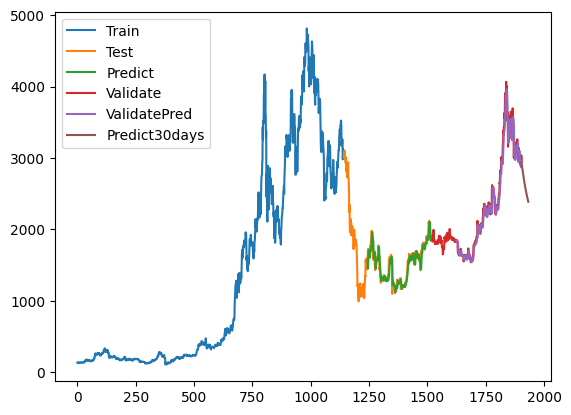

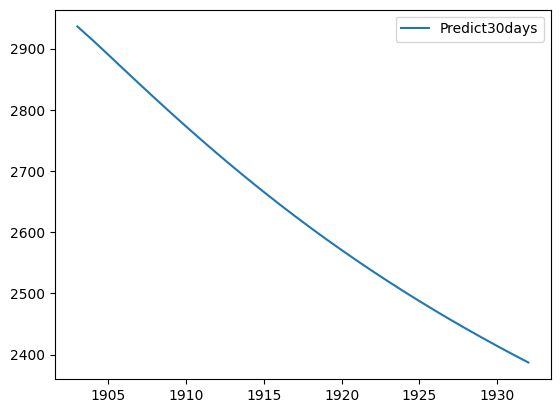

In [50]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# Vẽ hình
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict30days'])
plt.show()

In [52]:
# 15. Dự báo 60 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=321
i=0
while(i<60):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.38582733 0.38856528 0.3923834  0.3883941  0.38285424 0.36967722
 0.37434937 0.37327248 0.3727344  0.37646655 0.37599429 0.37467081
 0.40325706 0.38897126 0.38729508 0.38563929 0.3830793  0.38009154
 0.37826418 0.37868132 0.37891762 0.37313908 0.37830326 0.36996768
 0.37161394 0.37468063 0.3721702  0.37523044 0.37657555 0.37244386
 0.37127796 0.3746024  0.36764663 0.36680578 0.36522679 0.36677418
 0.36517344 0.36506215 0.37120246 0.37088133 0.37012749 0.3693556
 0.36973112 0.36768714 0.36873056 0.36506085 0.36053597 0.33485777
 0.32975546 0.33156911 0.33484045 0.33110056 0.32400142 0.33365409
 0.32954266 0.32805174 0.32664191 0.32902547 0.32795014 0.34438503
 0.33914976 0.32649991 0.32285256 0.32466777 0.3244747  0.32310015
 0.32394544 0.32365254 0.32691661 0.32447898 0.3242715  0.32037199
 0.3065059  0.31518226 0.31849166 0.32252993 0.32564937 0.32428412
 0.32166262 0.32473618 0.32605441 0.32166132 0.31345463 0.31536069
 0.31548607 0.31272005 0.3143088  0.31539236 0.3162

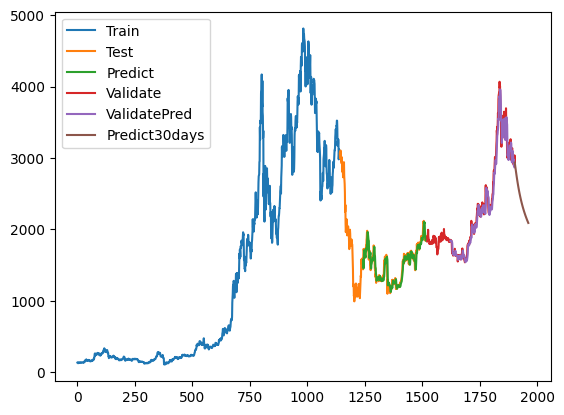

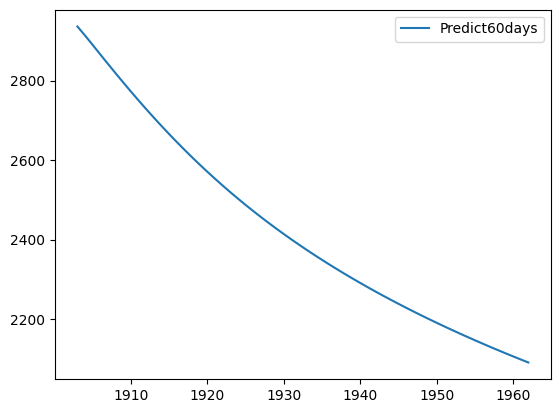

In [53]:
# 16.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# Vẽ hình
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict60days'])
plt.show()

In [55]:
# 17. Dự báo 90 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=321
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.38582733 0.38856528 0.3923834  0.3883941  0.38285424 0.36967722
 0.37434937 0.37327248 0.3727344  0.37646655 0.37599429 0.37467081
 0.40325706 0.38897126 0.38729508 0.38563929 0.3830793  0.38009154
 0.37826418 0.37868132 0.37891762 0.37313908 0.37830326 0.36996768
 0.37161394 0.37468063 0.3721702  0.37523044 0.37657555 0.37244386
 0.37127796 0.3746024  0.36764663 0.36680578 0.36522679 0.36677418
 0.36517344 0.36506215 0.37120246 0.37088133 0.37012749 0.3693556
 0.36973112 0.36768714 0.36873056 0.36506085 0.36053597 0.33485777
 0.32975546 0.33156911 0.33484045 0.33110056 0.32400142 0.33365409
 0.32954266 0.32805174 0.32664191 0.32902547 0.32795014 0.34438503
 0.33914976 0.32649991 0.32285256 0.32466777 0.3244747  0.32310015
 0.32394544 0.32365254 0.32691661 0.32447898 0.3242715  0.32037199
 0.3065059  0.31518226 0.31849166 0.32252993 0.32564937 0.32428412
 0.32166262 0.32473618 0.32605441 0.32166132 0.31345463 0.31536069
 0.31548607 0.31272005 0.3143088  0.31539236 0.3162

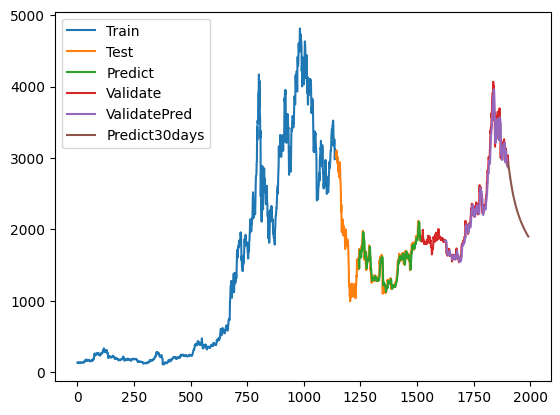

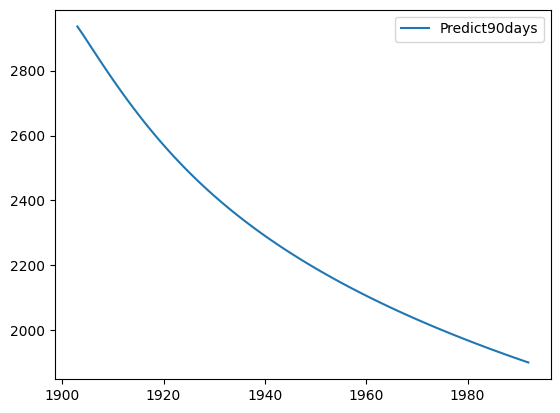

In [56]:
# 18.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# Vẽ hình
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict90days'])
plt.show()